# **DATA LOADING AND INITIAL EXPLORATIONS**

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Load the dataset
df = pd.read_csv('merged_ml_dataset.csv')

# Initial exploration
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nSummary statistics:")
print(df.describe())

Dataset shape: (15245, 35)

First few rows:
  pdb_id Affinity Data  pKd pKi pIC50 ligand_id  Molecular Weight  \
0   6ugp    Ki=685.5nM           6.16       Q7A           232.644   
1   6ugq     Ki=28.2nM           7.55       Q7A           232.644   
2   6ugr    Ki=533.6nM           6.27       Q71           216.190   
3   6ugz     Ki=19.1nM           7.72       Q71           216.190   
4   6uh0    Ki=853.1nM           6.07       PX7           212.226   

   ligand_atoms_x  Polar Surface Area  XLOGP3  h_bond_donors  \
0            19.0               83.65    0.76            2.0   
1            19.0               83.65    0.76            2.0   
2            19.0               83.65    0.23            2.0   
3            19.0               83.65    0.23            2.0   
4            22.0               74.86    0.32            1.0   

   h_bond_acceptors  ...  ligand_P pi_stacking  metal_coordination  \
0               3.0  ...         0           0                   0   
1               

# **DATA CLEANING AND PREPROCESSING**

In [19]:
# Remove the whole row in datset which carry the null value
df = df.dropna(subset=['affinity_value', 'affinity_units','Molecular Weight' ,'ligand_atoms_x' ,'Polar Surface Area' , 'XLOGP3','h_bond_donors','h_bond_acceptors','Rotatable bonds','affinity_type'])

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check the shape of data after removing the row
print(f"Dataset shape: {df.shape}")

# Convert categorical variables to numerical
df['affinity_type'] = df['affinity_type'].astype('category').cat.codes

# Check for duplicates
print(f"\nNumber of duplicates: {df.duplicated().sum()}")


Missing values:
pdb_id                         0
Affinity Data                  0
pKd pKi pIC50                  0
ligand_id                      0
Molecular Weight               0
ligand_atoms_x                 0
Polar Surface Area             0
XLOGP3                         0
h_bond_donors                  0
h_bond_acceptors               0
Rotatable bonds                0
affinity_type                  0
affinity_value                 0
affinity_units                 0
pKd_standardized               0
ligand_atoms_y                 0
hbonds                         0
hydrophobic                    0
salt_bridges                   0
pocket_atoms                   0
pocket_volume                  0
ligand_C                       0
ligand_N                       0
ligand_O                       0
ligand_S                       0
ligand_P                       0
pi_stacking                    0
metal_coordination             0
polar_contacts                 0
buried_surface_area       

In [23]:
# Removing Duplicate
df = df.drop_duplicates()
print(f"\nNumber of duplicates: {df.duplicated().sum()}")


# Check the shape of data after removing the row
print(f"Dataset shape: {df.shape}")

print(df.head())


Number of duplicates: 0
Dataset shape: (12526, 35)
  pdb_id Affinity Data  pKd pKi pIC50 ligand_id  Molecular Weight  \
0   6ugp    Ki=685.5nM           6.16       Q7A           232.644   
1   6ugq     Ki=28.2nM           7.55       Q7A           232.644   
2   6ugr    Ki=533.6nM           6.27       Q71           216.190   
3   6ugz     Ki=19.1nM           7.72       Q71           216.190   
4   6uh0    Ki=853.1nM           6.07       PX7           212.226   

   ligand_atoms_x  Polar Surface Area  XLOGP3  h_bond_donors  \
0            19.0               83.65    0.76            2.0   
1            19.0               83.65    0.76            2.0   
2            19.0               83.65    0.23            2.0   
3            19.0               83.65    0.23            2.0   
4            22.0               74.86    0.32            1.0   

   h_bond_acceptors  ...  ligand_P  pi_stacking  metal_coordination  \
0               3.0  ...         0            0                   0   
1     

3: **FEATURE ENGINEERING**

In [27]:
# Create new features that might be relevant
#The ratio: It helps you understand the proportion of carbon atoms compared to other atoms (N, O, S, P) in the ligand, which might have biological relevance, such as molecule interactions or solubility properties.
#To prevent this error, you add a small number (1e-6) to the denominator. This ensures that if the sum of N, O, S, and P is zero, it won’t break the program

df['ligand_atom_ratio'] = df['ligand_C'] / (df['ligand_N'] + df['ligand_O'] + df['ligand_S'] + df['ligand_P'] + 1e-6)
df['h_bond_total'] = df['h_bond_donors'] + df['h_bond_acceptors']
df['polar_nonpolar_ratio'] = df['Polar Surface Area'] / (df['Molecular Weight'] + 1e-6)

# Log transform the target variable if needed (pKd is already logarithmic)
# We'll use pKd_standardized as our target

# Separate features and target
X = df.drop(columns=['pdb_id', 'ligand_id', 'pKd_standardized', 'affinity_value'])
y = df['pKd_standardized']

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

print(f"Numerical features: {len(numerical_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

Numerical features: 31
Categorical features: 2


# 4: **DATA SPLITTING Train, Validation, and Test Sets**

In [28]:
# Split data into train, validation, and test sets (70/15/15)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale numerical features
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

Training set size: 8768
Validation set size: 1879
Test set size: 1879


# **MODEL TRAINING**

In [29]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regression': SVR()
}

# Train and evaluate initial models
results = {}
for name, model in models.items():
    model.fit(X_train[numerical_cols], y_train)  # Using only numerical cols for simplicity
    y_pred = model.predict(X_val[numerical_cols])
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name}: RMSE = {rmse:.4f}, R2 = {r2:.4f}")

# Display initial results
results_df = pd.DataFrame(results).T
print("\nInitial Model Performance:")
print(results_df.sort_values('R2', ascending=False))

Linear Regression: RMSE = 1.2137, R2 = 0.6262
Ridge Regression: RMSE = 1.2136, R2 = 0.6262
Lasso Regression: RMSE = 1.5986, R2 = 0.3515
Random Forest: RMSE = 1.1561, R2 = 0.6608
Gradient Boosting: RMSE = 1.1709, R2 = 0.6521
Support Vector Regression: RMSE = 1.3653, R2 = 0.5270

Initial Model Performance:
                               RMSE        R2
Random Forest              1.156124  0.660804
Gradient Boosting          1.170894  0.652082
Ridge Regression           1.213640  0.626216
Linear Regression          1.213653  0.626208
Support Vector Regression  1.365298  0.526961
Lasso Regression           1.598591  0.351491


In [30]:
# Hyperparameter tuning for the best performing models
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Random Forest tuning
rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train[numerical_cols], y_train)
best_rf = grid_search_rf.best_estimator_

# Gradient Boosting tuning
gb = GradientBoostingRegressor(random_state=42)
grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_gb.fit(X_train[numerical_cols], y_train)
best_gb = grid_search_gb.best_estimator_

# Evaluate tuned models
tuned_models = {
    'Tuned Random Forest': best_rf,
    'Tuned Gradient Boosting': best_gb
}

tuned_results = {}
for name, model in tuned_models.items():
    model.fit(X_train[numerical_cols], y_train)
    y_pred = model.predict(X_val[numerical_cols])
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    tuned_results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name}: RMSE = {rmse:.4f}, R2 = {r2:.4f}")

# Display tuned results
tuned_results_df = pd.DataFrame(tuned_results).T
print("\nTuned Model Performance:")
print(tuned_results_df.sort_values('R2', ascending=False))

KeyboardInterrupt: 

In [31]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Simplified + Randomized parameter distributions (instead of grid search)
param_dist_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

param_dist_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4]
}

# Fast Randomized SearchCV for Random Forest
rf = RandomForestRegressor(random_state=42)
random_search_rf = RandomizedSearchCV(
    rf, param_distributions=param_dist_rf,
    n_iter=5, cv=3, scoring='neg_mean_squared_error',
    n_jobs=-1, random_state=42
)
random_search_rf.fit(X_train[numerical_cols], y_train)
best_rf = random_search_rf.best_estimator_

# Fast Randomized SearchCV for Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
random_search_gb = RandomizedSearchCV(
    gb, param_distributions=param_dist_gb,
    n_iter=5, cv=3, scoring='neg_mean_squared_error',
    n_jobs=-1, random_state=42
)
random_search_gb.fit(X_train[numerical_cols], y_train)
best_gb = random_search_gb.best_estimator_

# Evaluate the tuned models on validation data
tuned_models = {
    'Tuned Random Forest': best_rf,
    'Tuned Gradient Boosting': best_gb
}

tuned_results = {}
for name, model in tuned_models.items():
    model.fit(X_train[numerical_cols], y_train)
    y_pred = model.predict(X_val[numerical_cols])
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    tuned_results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name}: RMSE = {rmse:.4f}, R2 = {r2:.4f}")

# Convert to DataFrame for easy viewing
tuned_results_df = pd.DataFrame(tuned_results).T
print("\n🚀 Tuned Model Performance:")
print(tuned_results_df.sort_values('R2', ascending=False))


Tuned Random Forest: RMSE = 1.1557, R2 = 0.6610
Tuned Gradient Boosting: RMSE = 1.1551, R2 = 0.6614

🚀 Tuned Model Performance:
                             RMSE        R2
Tuned Gradient Boosting  1.155113  0.661397
Tuned Random Forest      1.155726  0.661038


<ipython-input-32-4f091507c28e>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=all_results.index, y=all_results['R2'], palette="viridis")


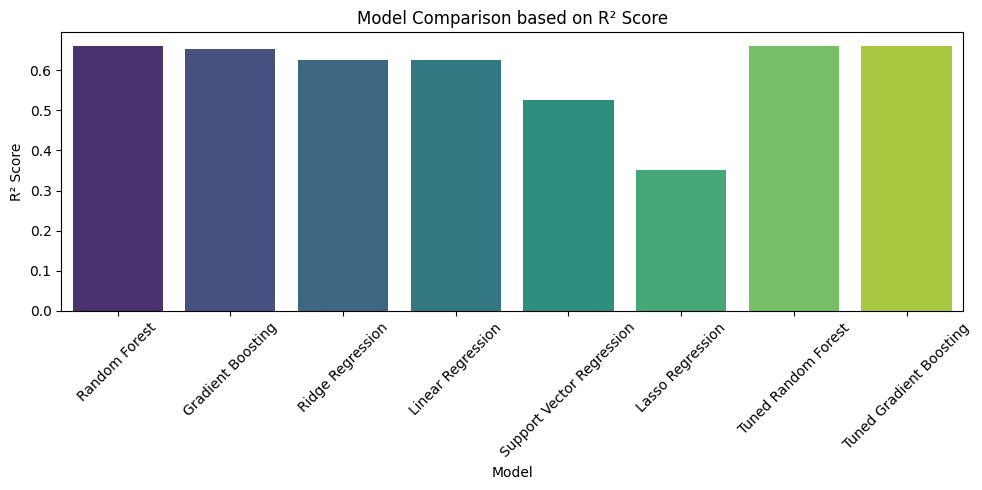

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine initial and tuned results for comparison
initial_results = {
    'Random Forest': {'RMSE': 1.1561, 'R2': 0.6608},
    'Gradient Boosting': {'RMSE': 1.1709, 'R2': 0.6521},
    'Ridge Regression': {'RMSE': 1.2136, 'R2': 0.6262},
    'Linear Regression': {'RMSE': 1.2137, 'R2': 0.6262},
    'Support Vector Regression': {'RMSE': 1.3653, 'R2': 0.5270},
    'Lasso Regression': {'RMSE': 1.5986, 'R2': 0.3515}
}

# Merge with tuned results
all_results = pd.DataFrame(initial_results).T
all_results = pd.concat([all_results, tuned_results_df])

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=all_results.index, y=all_results['R2'], palette="viridis")
plt.xticks(rotation=45)
plt.title('Model Comparison based on R² Score')
plt.ylabel('R² Score')
plt.xlabel('Model')
plt.tight_layout()
plt.show()


<ipython-input-35-107fee00b939>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette="magma")


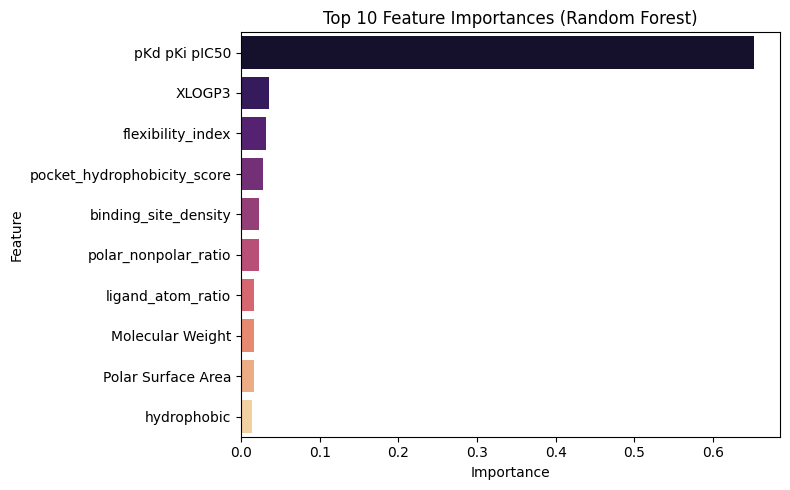

In [35]:
importances = best_rf.feature_importances_
feat_names = X_train[numerical_cols].columns
feat_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette="magma")
plt.title('Top 10 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


<ipython-input-36-9cd05d859570>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette="magma")


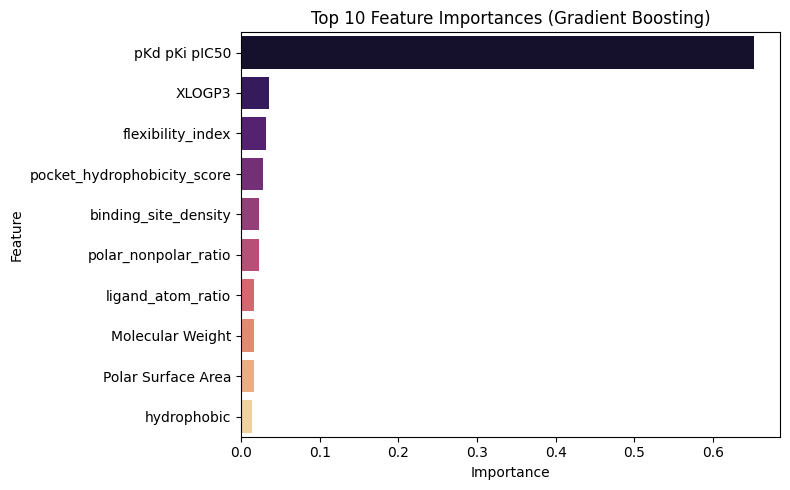

In [36]:
importances_gb = best_gb.feature_importances_
feat_names = X_train[numerical_cols].columns
feat_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette="magma")
plt.title('Top 10 Feature Importances (Gradient Boosting)')
plt.tight_layout()
plt.show()

# Follow same logic to plot


In [37]:
import joblib

# Save best model
joblib.dump(best_rf, 'best_random_forest_model.pkl')
joblib.dump(best_gb, 'best_gradient_boosting_model.pkl')


['best_gradient_boosting_model.pkl']

In [38]:
# Save summary table
final_results = pd.concat([pd.DataFrame(initial_results).T, tuned_results_df])
final_results.to_csv('model_comparison_summary.csv')
print("📄 Summary saved to 'model_comparison_summary.csv'")


📄 Summary saved to 'model_comparison_summary.csv'
